In [1]:
import os
import json
import pandas as pd
import subprocess
import re

def get_single_result(file):
    file_base = file.split(".jsonl")[0]
    print(file_base)
    try:
        os.remove(file_base+"_eval_results.json")
    except:
        pass
    # run evalplus.evaluate
    result = subprocess.run(["evalplus.evaluate",
                    "--dataset", "humaneval", "--samples", file, "--i-just-wanna-run"], 
                            text=True, capture_output=True, check=False)

    # print(result.stdout)
    # extract results from stdout
    print(result.stdout)
    regex = re.compile(r"'pass@1': ([0-9.]+)")
    matches = regex.findall(result.stdout)
    
    base = float(matches[0]) if matches else None
    base_extra = float(matches[1]) if matches else None

    to_add = {'file': [file], 'base': [base*100], 'base_extra': [base_extra*100]}
    print(to_add)
    new_row = pd.DataFrame(to_add)
    return new_row

def get_jsonl_files():
    files = os.listdir()
    return [file for file in files if file.endswith(".jsonl")]

def process_file(jsonl_file, retried=False):
    eval_file = jsonl_file.replace(".jsonl", "_eval_results.json")

    try:
        with open(eval_file, "r") as file:
            eval_data = json.load(file)
            evals = eval_data.get('eval')
    except:
        if not retried:  # If this is the first attempt, compute and save the missing _eval_results.json file and retry
            get_single_result(jsonl_file)
            return process_file(jsonl_file, retried=True) 
        else:  # If this is a retry and it still fails, skip this file
            print("Failed:", jsonl_file)
            return None

    total_def_count, successful_def_count, total_success_count, total_base_success_count, total_pass_count = calculate_metrics(jsonl_file, evals)

    if total_pass_count > 1 and not retried:  # If pass count is greater than 1 and this is the first attempt, recompute and retry
        get_single_result(jsonl_file)
        return process_file(jsonl_file, retried=True) 
    if total_pass_count > 1 and retried:
        print("Incomplete file:", jsonl_file, total_pass_count)
        return None

    success_rate = total_success_count / 164  # Total number of problems
    return (jsonl_file, total_def_count, successful_def_count, 100*total_success_count / 164, 100*total_base_success_count / 164, success_rate, total_pass_count)

def calculate_metrics(jsonl_file, evals):
    total_def_count = 0
    successful_def_count = 0
    total_success_count = 0
    total_base_success_count = 0
    total_pass_count = 0

    with open(jsonl_file, "r") as file:
        for index, line in enumerate(file):
            data_row = json.loads(line)
            completion = data_row.get("completion")
            if completion:
                if completion.strip() == "pass":
                    total_pass_count += 1
                if len(completion.split("def")) > 2:
                    total_def_count += 1
                    problem = f'HumanEval/{index}'
                    result = evals.get(problem, {"plus": [["unknown"]]})
                    base_status = result.get('plus')[0][0]
                    if base_status == 'success':
                        successful_def_count += 1

    for problem, result in evals.items():
        base_status = result.get('base')[0][0]
        if base_status == 'success':
            total_base_success_count += 1
        plus_status = result.get('plus')[0][0]
        if plus_status == 'success':
            total_success_count += 1

    return total_def_count, successful_def_count, total_success_count, total_base_success_count, total_pass_count

def calculate_results():
    jsonl_files = get_jsonl_files()

    data = []
    for jsonl_file in jsonl_files:
        result = process_file(jsonl_file)
        if result:
            data.append(result)

    df = pd.DataFrame(data, columns=['file', 'total_def_count', 'successful_def_count', 'total_success_count', 'total_base_success_count', 'success_rate', 'total_pass_count'])
    df = df.sort_values('success_rate', ascending=False)

    return df

# Use calculate_results() to get your DataFrame
df = calculate_results()

print("Done!")

df


Done!


,file,total_def_count,successful_def_count,total_success_count,total_base_success_count,success_rate,total_pass_count
20,gpt4_final_500c_long.jsonl,18,12,78.048780,85.365854,0.780488,1
61,gpt3_final_500c_long.jsonl,11,3,60.365854,68.902439,0.603659,1
17,Claude_Plus_custom_md.jsonl,16,8,40.853659,53.048780,0.408537,0
64,Claude_custom.jsonl,13,1,39.024390,47.560976,0.390244,0
21,Bard_custom.jsonl,17,7,36.585366,44.512195,0.365854,0
...,...,...,...,...,...,...,...
93,togethercomputer_RedPajama-INCITE-Instruct-3B-...,43,1,2.439024,3.048780,0.024390,0
37,togethercomputer_RedPajama-INCITE-7B-Instruct_...,21,0,2.439024,2.439024,0.024390,0
66,togethercomputer_RedPajama-INCITE-Instruct-3B-...,78,2,2.439024,3.048780,0.024390,0
46,TheBloke_open-llama-7b-open-instruct-GPTQ_ALPA...,21,0,1.219512,1.219512,0.012195,0


In [2]:
df = df.rename(columns={'total_base_success_count': 'HumanEval', 'total_success_count': 'Eval+'})

In [3]:
df.to_csv('results.csv', index=False)

In [4]:
df = pd.read_csv('results.csv')

df_sorted = df.sort_values(['Eval+', 'HumanEval'])

In [5]:
def get_base(f):
    if "500c" in f or "Claude" in f or "Bard" in f:
        return f.split(".jsonl")[0]
    return "".join(f.split("_")[1:]).split("-GPTQ")[0].split(".jsonl")[0].split("ALPACA")[0].split("ALPACA")[0].split("FALCON")[0].split("QA")[0].split("H2O")[0]

df_sorted['base_model'] = df_sorted['file'].apply(get_base)

In [6]:
def get_prompt(f):
    base = get_base(f)
    print(base)
    remainder = f.split(base)[1].replace(".jsonl","").replace("MD",".MD").replace("MARKDOWN",".MD").replace("-GPTQ_","").replace("_DEBUG","").replace("_FIXED","")
    remainder = remainder.replace("_"," ").split("STARPLUS")[0].replace("-GPTQ-4bit-128g.no-act-order.safetensors","").replace("FALCON FULL","").replace("LONG","")
    remainder = remainder.replace("VICUNA VERYSHORT","VERY SHORT").replace("MEMSPLIT","").replace(" OLD PARSER BAD NL", "OLD SETTINGS").replace("PREFIX1", "PREFIX").replace("openllama", "")
    remainder = remainder.replace("RECALC","")
    return remainder.strip()

df_sorted['prompt'] = df_sorted['file'].apply(get_prompt)

open-llama-7b-open-instruct
Wizard-Vicuna-7B-Uncensored
RedPajama-INCITE-7B-Instruct
RedPajama-INCITE-Instruct-3B-v1
RedPajama-INCITE-Instruct-3B-v1
RedPajama-INCITE-7B-Instruct
Wizard-Vicuna-7B-Uncensored
gpt4-x-alpaca-13b-native-4bit-128g
wizardLM-7B
vicuna-7B
gpt4-x-alpaca-13b-native-4bit-128g
Wizard-Vicuna-13B-Uncensored
guanaco-7B
gpt4-x-alpaca-13b-native-4bit-128g
falcon-7b-instruct
wizardLM-7B
wizardLM-7B
wizardLM-7B
h2ogpt-gm-oasst1-en-2048-falcon-7b-v2
Manticore-13B-Chat-Pyg-Guanaco
guanaco-7B
vicuna-7B
wizardLM-7B
Wizard-Vicuna-30B-Uncensored
Manticore-13B-Chat-Pyg-Guanaco
guanaco-65B
Manticore-13B-Chat-Pyg-Guanaco
VicUnlocked-30B-LoRA
Wizard-Vicuna-13B-Uncensored
guanaco-13B
guanaco-13B
wizardLM-13B-1.0
guanaco-13B
guanaco-65B
starcoderplus
vicuna-13B-1.1
vicuna-13B-1.1
guanaco-33B
VicUnlocked-30B-LoRA
wizard-vicuna-13B
starcoderplus
Manticore-13B
Wizard-Vicuna-30B-Uncensored
wizard-vicuna-13B
Manticore-13B
wizardLM-13B-1.0
starcoderplus
guanaco-33B
Manticore-13B
starcoderpl

In [7]:
def final_replace(f):
    f = f.replace("_custom","").replace("_md", "").replace("_final_500c_long","").replace("gpt3", "GPT3").replace("gpt4", "GPT4").replace("H2O h2o", "H2O")
    return f.strip()

df_sorted['human name'] = (df_sorted['base_model'] + " " + df_sorted['prompt']).apply(final_replace)

In [8]:
list(df_sorted['human name'])

['open-llama-7b-open-instruct ALPACA PREFIX',
 'Wizard-Vicuna-7B-Uncensored VICUNA .MD',
 'RedPajama-INCITE-7B-Instruct Q A .MD',
 'RedPajama-INCITE-Instruct-3B-v1 Q A .MD',
 'RedPajama-INCITE-Instruct-3B-v1 Q A MEDIUM',
 'RedPajama-INCITE-7B-Instruct Q A MEDIUM',
 'Wizard-Vicuna-7B-Uncensored VICUNA MEDIUM',
 'GPT4-x-alpaca-13b-native-4bit-128g ALPACA MEDIUM',
 'wizardLM-7B ALPACA OLD SETTINGS HIGHTEMP',
 'vicuna-7B -GPTQ-4bit-128g VICUNA MEDIUM',
 'GPT4-x-alpaca-13b-native-4bit-128g ALPACA',
 'Wizard-Vicuna-13B-Uncensored VICUNA MEDIUM',
 'guanaco-7B ALPACA .MD',
 'GPT4-x-alpaca-13b-native-4bit-128g ALPACA .MD',
 'falcon-7b-instruct FALCON',
 'wizardLM-7B ALPACA',
 'wizardLM-7B ALPACA',
 'wizardLM-7B ALPACA .MD',
 'h2ogpt-gm-oasst1-en-2048-falcon-7b-v2 H2O',
 'Manticore-13B-Chat-Pyg-Guanaco ALPACA',
 'guanaco-7B ALPACA MEDIUM',
 'vicuna-7B -GPTQ-4bit-128g VICUNA .MD',
 'wizardLM-7B ALPACA MEDIUM',
 'Wizard-Vicuna-30B-Uncensored VICUNA MEDIUM',
 'Manticore-13B-Chat-Pyg-Guanaco ALPACA 

In [9]:
import pandas as pd

# Convert the Eval+ and HumanEval columns to numeric values
df_sorted['Eval+'] = pd.to_numeric(df_sorted['Eval+'])
df_sorted['HumanEval'] = pd.to_numeric(df_sorted['HumanEval'])

# Sort the DataFrame first by 'base_model', then by 'Eval+' and 'HumanEval' in descending order
df_sorted = df_sorted.sort_values(by=['base_model', 'Eval+', 'HumanEval'], ascending=[True, False, False])

# Group by 'base_model' and get the index of the first max 'Eval+' in each group
idx = df_sorted.groupby('base_model')['Eval+'].idxmax()

# Use the indices to get the corresponding rows from df
best_eval_df = df_sorted.loc[idx]

best_eval_df = best_eval_df.sort_values(by=['Eval+', 'HumanEval'], ascending=[True, True])


In [10]:
df_sorted = df_sorted.sort_values(['Eval+', 'HumanEval'])

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_df(to_plt, names = 'human name', height=22, width=14, offset=3, width_threshold=10, plot_name='plot.jpg'):
    # Set a seaborn style
    sns.set_style("whitegrid")

    # Create figure and axes (subplots) and set figure size
    fig, ax = plt.subplots(figsize=(width, height))

    # Define bar colors with seaborn color palette
    colors = ["#1f77b4", "#ff7f0e"]  # change these to any colors you prefer

    # Create thicker horizontal bar plot
    to_plt.plot.barh(x=names, y=['HumanEval', 'Eval+'], ax=ax, color=colors, edgecolor='black', linewidth=1.5)

    # Customize the plot
    ax.set_xlabel('% Tests Passed', fontsize=14)
    ax.set_title('HumanEval+ Programming Performance (164 Problems)', fontsize=16)

    # Remove y axis label
    ax.set_ylabel('') 

    # Reverse the order of legend labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='lower right')

    # Increase yticks font size
    plt.yticks(fontsize=12)

    # Add labels inside the bars
    for p in ax.patches:
        width = p.get_width()
        if width < width_threshold:
            # Place label to the right of the bar
            plt.text(width + 0.4,  
                     p.get_y() + p.get_height() / 2,
                     '{:1.1f}%'.format(width),
                     ha='left',
                     va='center',
                     fontsize=12)
        else:
            # Place label inside the bar
            plt.text(width - offset,  
                     p.get_y() + p.get_height() / 2,
                     '{:1.1f}%'.format(width),
                     ha='center',
                     va='center',
                     color='white',
                     fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.savefig(plot_name, format='jpeg', dpi=300)
    plt.show()

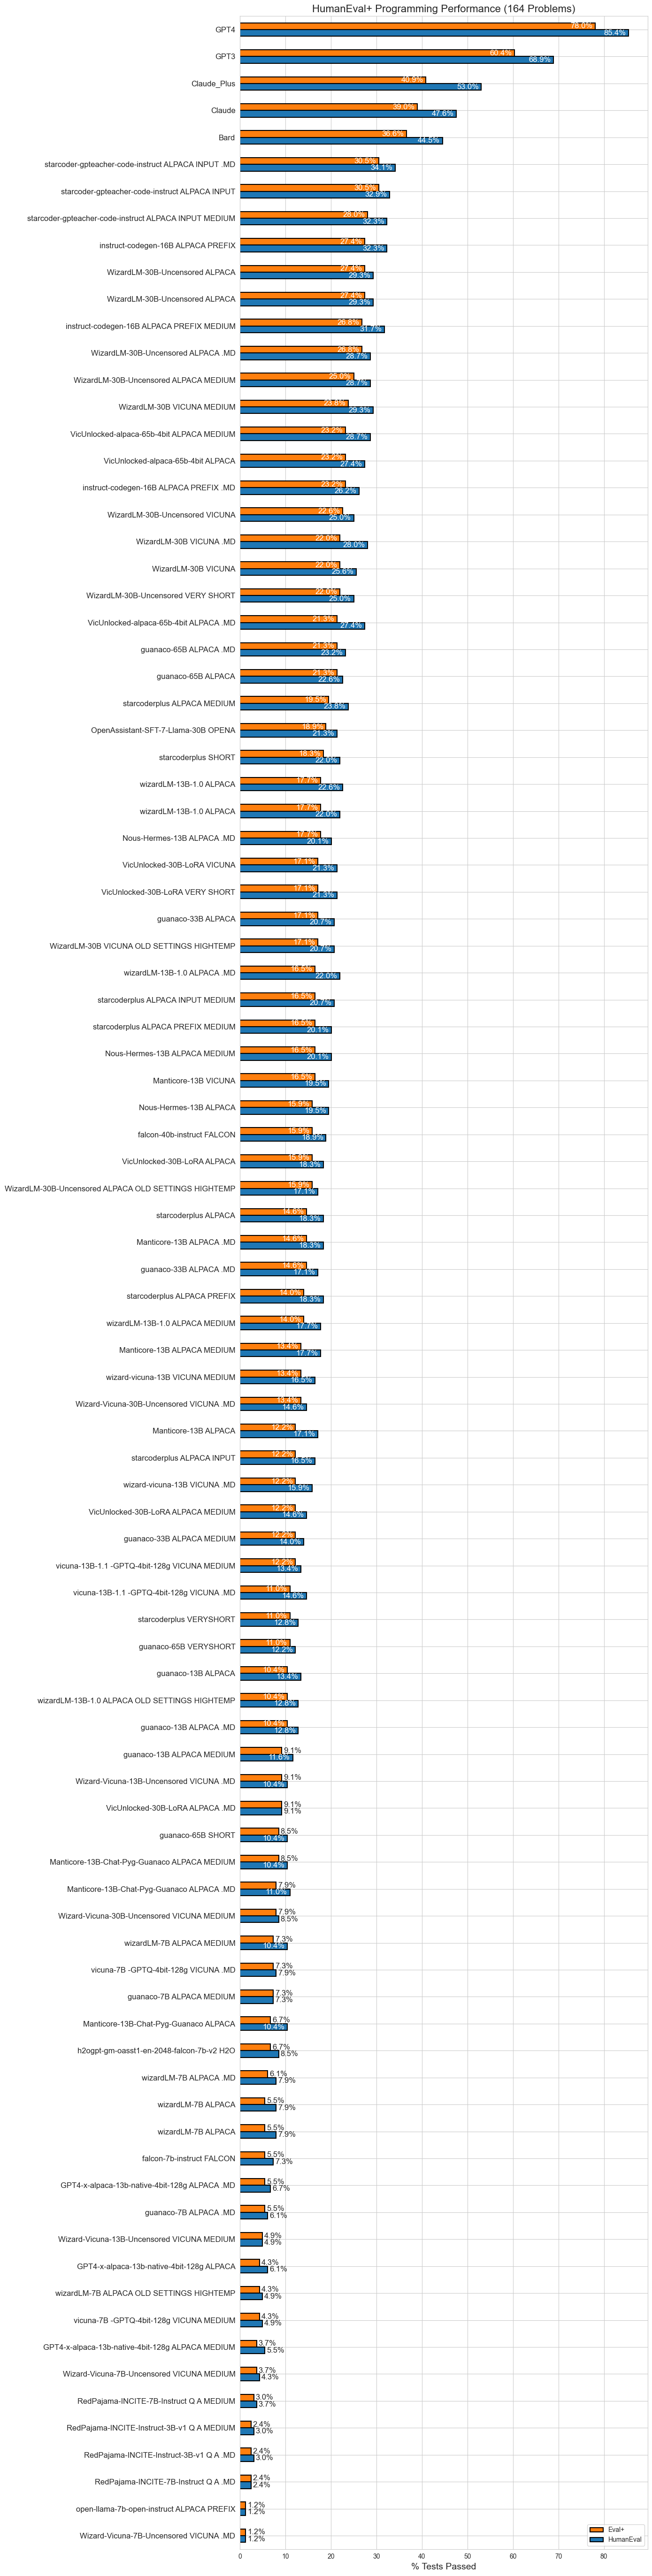

In [12]:
plot_df(df_sorted, height=55, plot_name="MasterResults.jpg")

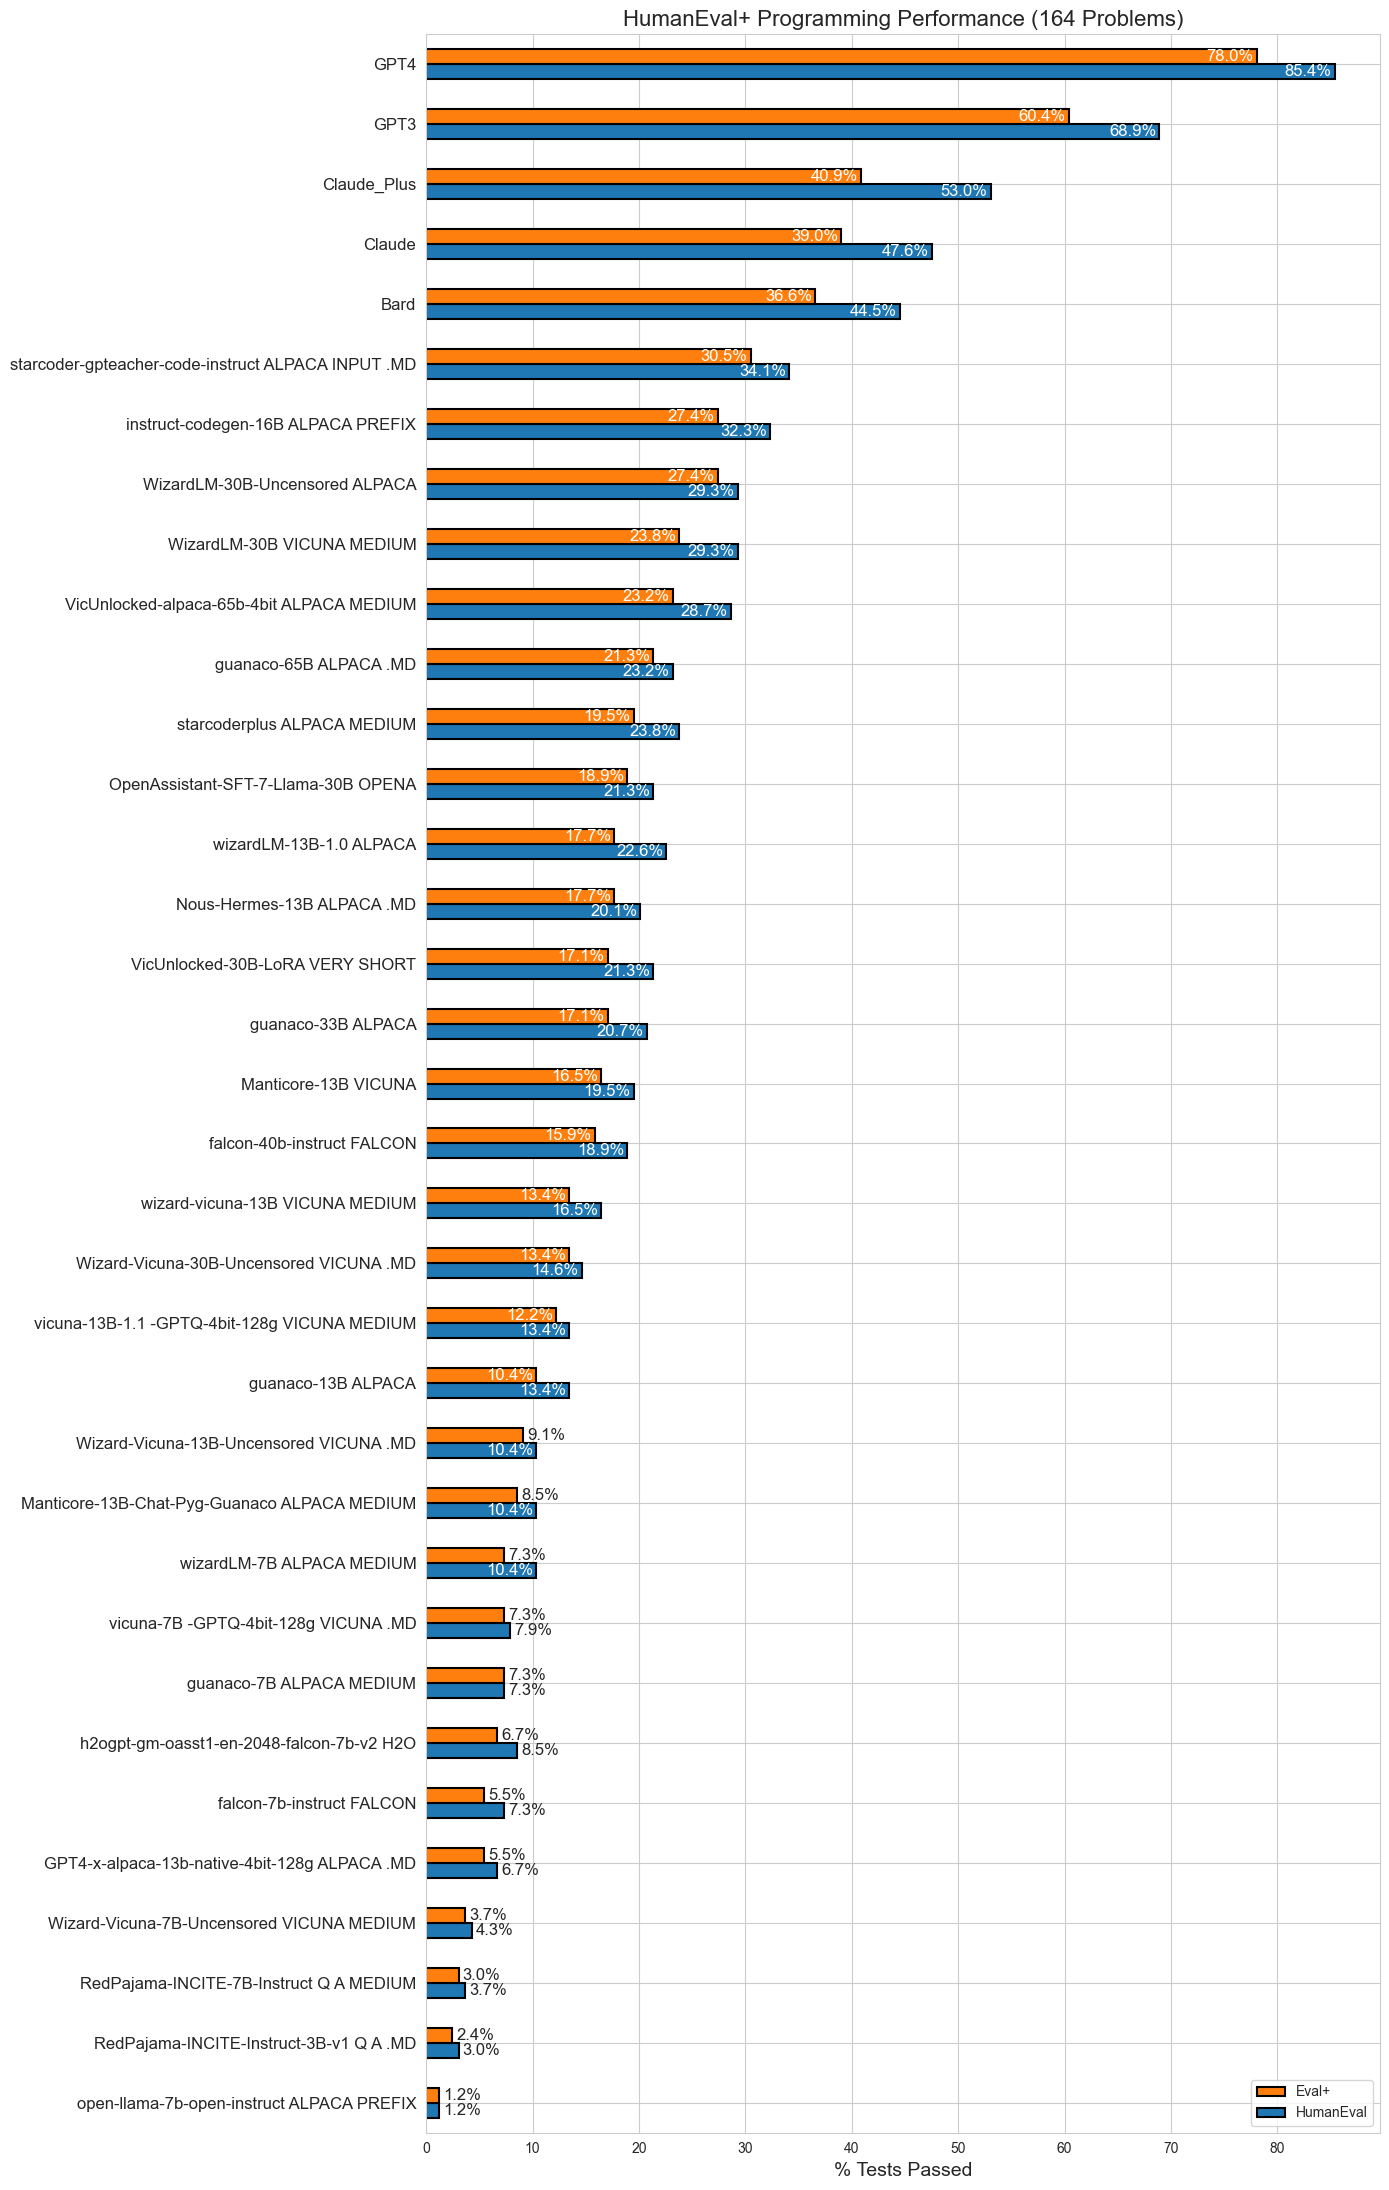

In [13]:
plot_df(best_eval_df, names = 'human name', offset=2.5, plot_name="HumanEval_v3.jpg")

In [14]:
import json

counts = {}

for filename in df_sorted['file']:
    counts[filename] = 0  # Initialize count to 0
    with open(filename, "r") as file:
        for line in file:
            json_data = json.loads(line)
            if "    pass" == json_data["completion"]:
                counts[filename] += 1  # Increment count for each matching line

# Display the counts
for filename, count in counts.items():
    print("File:", filename)
    print("Count:", count)
    print()

File: TheBloke_Wizard-Vicuna-7B-Uncensored-GPTQ_VICUNA_MARKDOWN.jsonl
Count: 0

File: TheBloke_open-llama-7b-open-instruct-GPTQ_ALPACA_PREFIX_openllama.jsonl
Count: 0

File: togethercomputer_RedPajama-INCITE-7B-Instruct_Q_A_MARKDOWN.jsonl
Count: 0

File: togethercomputer_RedPajama-INCITE-Instruct-3B-v1_Q_A_MARKDOWN.jsonl
Count: 0

File: togethercomputer_RedPajama-INCITE-Instruct-3B-v1_Q_A_MEDIUM.jsonl
Count: 0

File: togethercomputer_RedPajama-INCITE-7B-Instruct_Q_A_MEDIUM.jsonl
Count: 0

File: TheBloke_Wizard-Vicuna-7B-Uncensored-GPTQ_VICUNA_MEDIUM.jsonl
Count: 0

File: anon8231489123_gpt4-x-alpaca-13b-native-4bit-128g_ALPACA_MEDIUM.jsonl
Count: 0

File: TheBloke_vicuna-7B-GPTQ-4bit-128g_VICUNA_MEDIUM.jsonl
Count: 0

File: TheBloke_wizardLM-7B-GPTQ_ALPACA_DEBUG_LONG_OLD_PARSER_BAD_NL_HIGHTEMP.jsonl
Count: 0

File: anon8231489123_gpt4-x-alpaca-13b-native-4bit-128g_ALPACA_LONG_FIXED.jsonl
Count: 0

File: TheBloke_Wizard-Vicuna-13B-Uncensored-GPTQ_VICUNA_MEDIUM.jsonl
Count: 0

File: TheB

In [15]:
!ls

Aeala_VicUnlocked-alpaca-65b-4bit_ALPACA_LONG_FIXED_eval_results.json
Aeala_VicUnlocked-alpaca-65b-4bit_ALPACA_MARKDOWN_eval_results.json
Aeala_VicUnlocked-alpaca-65b-4bit_ALPACA_MD_RECALC.jsonl
Aeala_VicUnlocked-alpaca-65b-4bit_ALPACA_MD_RECALC_eval_results.json
Aeala_VicUnlocked-alpaca-65b-4bit_ALPACA_MEDIUM_RECALC.jsonl
Aeala_VicUnlocked-alpaca-65b-4bit_ALPACA_MEDIUM_RECALC_eval_results.json
Aeala_VicUnlocked-alpaca-65b-4bit_ALPACA_MEDIUM_eval_results.json
Aeala_VicUnlocked-alpaca-65b-4bit_ALPACA_MEMSPLIT.jsonl
Aeala_VicUnlocked-alpaca-65b-4bit_ALPACA_MEMSPLIT_eval_results.json
Bard_custom.jsonl
Bard_custom_eval_results.json
Claude_Plus_custom_md.jsonl
Claude_Plus_custom_md_eval_results.json
Claude_custom.jsonl
Claude_custom_eval_results.json
GeorgiaTechResearchInstitute_starcoder-gpteacher-code-instruct_ALPACA_INPUT_LONG_FIXED.jsonl
GeorgiaTechResearchInstitute_starcoder-gpteacher-code-instruct_ALPACA_INPUT_LONG_FIXED_eval_results.json
GeorgiaTechResearchInstitute_starcoder-gpteach

In [16]:
import os
import json
import pandas as pd

# List all files in the current directory
files = os.listdir()

# Filter only jsonl files
jsonl_files = [file for file in files if file.endswith(".jsonl")]

data = []

for jsonl_file in jsonl_files:
    with open(jsonl_file, "r") as file:
        count = 0
        for line in file:
            data_row = json.loads(line)
            completion = data_row.get("completion")
            if completion and len(completion.split("def")) > 2:
                count += 1
        data.append((jsonl_file, count))

# Create DataFrame
df = pd.DataFrame(data, columns=['file', 'def_count'])

# Sort DataFrame by count descending
df = df.sort_values('def_count', ascending=False)

print(df)


                                                 file  def_count
75  TheBloke_starcoderplus-GPTQ_SHORT_STARPLUS_7.j...        164
34  TheBloke_starcoderplus-GPTQ_VERYSHORT_STARPLUS...        164
35         TheBloke_guanaco-65B-GPTQ_VERYSHORT_.jsonl        164
10             TheBloke_guanaco-65B-GPTQ_SHORT_.jsonl        164
66  togethercomputer_RedPajama-INCITE-Instruct-3B-...         78
..                                                ...        ...
45  TheBloke_VicUnlocked-30B-LoRA-GPTQ_VICUNA_VERY...          6
88  TheBloke_VicUnlocked-30B-LoRA-GPTQ_VICUNA_LONG...          6
44  TheBloke_VicUnlocked-30B-LoRA-GPTQ_ALPACA_LONG...          6
33     TheBloke_falcon-7b-instruct-GPTQ_FALCON_.jsonl          4
27  TheBloke_VicUnlocked-30B-LoRA-GPTQ_ALPACA_MARK...          4

[94 rows x 2 columns]
